# Data Cleaning Notebook

With such a massive dataset, the cleaning process was both detailed and meticulous. Below, I provide a high-level overview of my general steps. More granular details, along with the specific justifications for my decisions, can be found within each corresponding section of this notebook.

## Overview

I cleaned each of the three datasets (crashes_df, people_df, and vehicles_df) with the primary goals of making the data more manageable and reducing noise by eliminating unnecessary features and handling null values.

Throughout the cleaning process, I kept my target variable, most_severe_injury, in focus. Since most_severe_injury is a crash-level feature, the analysis in this project is centered around crash-level data. This distinction was especially important when working with people_df (person-level data) and vehicles_df (vehicle-level data), as merging these datasets with crashes_df required careful attention to avoid many-to-many relationships that could skew feature values. For instance, merging without proper aggregation could lead to inflated counts or inaccurate distributions of features such as the “number of injured persons per crash.” Without aggregation, a single crash with multiple people involved would be duplicated for each person in people_df, leading to an overrepresentation of crashes and skewed averages or totals. Proper aggregation ensures that each crash appears only once in the merged dataset

To address this, I aggregated the cleaned people_df and vehicles_df into people_aggregated and vehicles_aggregated, respectively, before merging them with crashes_cleaned. This ensured a smooth merge process that maintained a one-to-one relationship with crash_record_id across the combined dataset.

In order to simplify the analysis, I then adjusted the target variable (most_severe_injury) into a binary classification: serious injuries (fatalities and incapacitating injuries) versus non-serious injuries (minor or no injuries). This adjustment focused the modeling on predicting significant crash outcomes, providing a clearer and more manageable classification.

The final merged dataset still contained over 600,000 records, which posed computational challenges. To address this, I employed stratified random sampling to create a representative subset of the data. This approach preserved the proportional distribution of classes in my target variable, most_severe_injury. To ensure reproducibility, I set a fixed random_state during sampling.

The resulting stratified sample, ready for modeling, was uploaded to Kaggle to streamline reproducibility and accessibility for others.

## 1.0 Importing Necessary Libraries

In [1]:
# for getting data
import os
import zipfile

# for managing data
import gc

# for checking runtime
import time

# for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# for feature selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### 1.1 Environment Setup and data loading

In [2]:
# Try block: Attempt to import the kaggle package
try:
    
    # Try to import the kaggle library
    import kaggle  
    
    # If successful, print that the package is installed
    print("Kaggle package is already installed.")

# Except block: If kaggle is not installed, install it using pip
except ModuleNotFoundError:
    
    # If kaggle is not found, print a message indicating that it's being installed
    print("Kaggle package not found. Installing...")  
    
    # Run pip install to install the kaggle package
    !pip install kaggle  

Kaggle package is already installed.


In [3]:
# Sets environment variable to point to the location of kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = './config' 

In [4]:
# Check if the KAGGLE_CONFIG_DIR environment variable is set
print(os.getenv('KAGGLE_CONFIG_DIR'))

./config


In [5]:
# Information about the dataset
dataset_name = 'ckucewicz/Chicago-Traffic-Data'
zip_filename = 'Chicago-Traffic-Data.zip' 
download_path = './data'
unzip_path = './data'

# Step 1: Downloads dataset from Kaggle, if not already downloaded
dataset_path = os.path.join(download_path, zip_filename)
if not os.path.exists(dataset_path):
    print(f"Downloading {dataset_name}...")
    os.system(f"kaggle datasets download -d {dataset_name} --path {download_path}")
else:
    print(f"{dataset_name} already downloaded.")

# Step 2: Unzips the downloaded file
print(f"Unzipping {zip_filename}...")
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Step 3: Loads the CSV files into pandas dataframes
csv_filenames = ['people.csv', 'traffic_crashes.csv', 'vehicles.csv']
dataframes = {}
for csv_filename in csv_filenames:
    csv_file = os.path.join(unzip_path, csv_filename)
    print(f"Loading CSV: {csv_filename}...")
    
    # Creates a variable name based on the CSV filename
    dataframe_name = csv_filename.split('.')[0]
    
    # Stores the dataframe in the dictionary
    dataframes[dataframe_name] = pd.read_csv(csv_file, low_memory = True)

     # Prints "Complete" once the CSV is successfully loaded
    print(f"Loading of {dataframe_name} complete.")
    print("-" * 50)

# stores each dataset in its own variable
traffic_crashes_df = dataframes['traffic_crashes']
people_df = dataframes['people']
vehicles_df = dataframes['vehicles']

ckucewicz/Chicago-Traffic-Data already downloaded.
Unzipping Chicago-Traffic-Data.zip...
Loading CSV: people.csv...


/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (19,23,24,25,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading of people complete.
--------------------------------------------------
Loading CSV: traffic_crashes.csv...


/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading of traffic_crashes complete.
--------------------------------------------------
Loading CSV: vehicles.csv...


/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (20,39,40,41,43,47,48,49,52,54,57,58,60,70) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading of vehicles complete.
--------------------------------------------------


## 2.0 Data Cleaning

### 2.1 Crashes

2.1.9 Reduce feature cardinality with bucketing:

2.1.11 Remove remaining nulls: .dropna()

Steps:
* **Preview Data**: `.head()`


* **Understand Structure**: `.info()`


* **Format Feature names and Row Values**: `.lower()`


* **Drop features with overly high null values**: `.isna().sum()/ len(df)` for percentage of nulls for each feature


* **Check for duplicates**: `.duplicated().sum()`


* **Keep or drop features with remaining nulls**:

    * make intentional decisions to keep or drop using `.value_counts()` distribution and domain knowledge


* **inspect remaining features**: `.value_counts()`; 

    * make intentional decisions to keep or drop using `.value_counts()` distribution and domain knowledge; 
    * make note of any features to keep that will need cleaning/cardinality reduction/etc.


* **remove unuseful features**: 

    * `.drop()` for list of features deemed not useful for analysis; 
    * store trimmed df as 'df_name_cleaned'
    

* **reduce feature cardinality with bucketing**:

    * `trafficway_type` and `lane_cnt`
    * `crash_hour`, `crash_day_of_week`, `crash_month`
    * `posted_speed_limit`
    * `traffic_control_device`
    * `prim_contributory_cause`
    * `most_severe_injury`
 
 
* **Convert data types**: 

    * stored data types to reflect true data types 
    * (text variables as strings, numeric variables as int, categorical as category, ect.)
    
 
* **remove remaining nulls**: `.dropna()`

#### 2.1.1 Preview Data: `.head()`

In [6]:
traffic_crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,...,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,NaN,08/18/2023 05:58:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,...,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,NaN,11/26/2019 08:38:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,...,0.0,0.0,1.0,0.0,8,3,11,NaN,NaN,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,NaN,08/18/2023 10:45:00 AM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,OTHER,...,0.0,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN


#### 2.1.2 Understand Structure: `.info()`

In [7]:
traffic_crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901446 entries, 0 to 901445
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                901446 non-null  object 
 1   CRASH_DATE_EST_I               66531 non-null   object 
 2   CRASH_DATE                     901446 non-null  object 
 3   POSTED_SPEED_LIMIT             901446 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         901446 non-null  object 
 5   DEVICE_CONDITION               901446 non-null  object 
 6   WEATHER_CONDITION              901446 non-null  object 
 7   LIGHTING_CONDITION             901446 non-null  object 
 8   FIRST_CRASH_TYPE               901446 non-null  object 
 9   TRAFFICWAY_TYPE                901446 non-null  object 
 10  LANE_CNT                       199022 non-null  float64
 11  ALIGNMENT                      901446 non-null  object 
 12  ROADWAY_SURFACE_COND          

#### 2.1.3 Format Feature names and Row Values: `.lower()`

In [8]:
traffic_crashes_df.columns = traffic_crashes_df.columns.str.lower()

In [9]:
# Convert all string values in object columns to lowercase
for col in traffic_crashes_df.select_dtypes(include='object').columns:
    traffic_crashes_df[col] = traffic_crashes_df[col].str.lower()

In [10]:
missing_percentage = round((traffic_crashes_df.isna().sum()/len(traffic_crashes_df)*100), 2)
missing_percentage

crash_record_id                   0.00
crash_date_est_i                 92.62
crash_date                        0.00
posted_speed_limit                0.00
traffic_control_device            0.00
device_condition                  0.00
weather_condition                 0.00
lighting_condition                0.00
first_crash_type                  0.00
trafficway_type                   0.00
lane_cnt                         77.92
alignment                         0.00
roadway_surface_cond              0.00
road_defect                       0.00
report_type                       3.11
crash_type                        0.00
intersection_related_i           77.03
not_right_of_way_i               95.45
hit_and_run_i                    68.64
damage                            0.00
date_police_notified              0.00
prim_contributory_cause           0.00
sec_contributory_cause            0.00
street_no                         0.00
street_direction                  0.00
street_name              

#### 2.1.4 Drop features with overly high null values: 

`.isna().sum()/ len(df)` for percentage of nulls for each feature

In [11]:
# selecting all features with 90% or more of its values are null
high_null_features = traffic_crashes_df.columns[(traffic_crashes_df.isna().sum() / len(traffic_crashes_df) * 100) >= 90]
high_null_features

# creating a list of features with 90% or more null values
high_null_features_list = list(high_null_features)
high_null_features_list

crashes_cleaned = traffic_crashes_df.drop(columns=high_null_features_list)


In [12]:
# selecting all features with 90% or more of its values are null
high_null_features = traffic_crashes_df.columns[(traffic_crashes_df.isna().sum() / len(traffic_crashes_df) * 100) >= 90]
high_null_features

Index(['crash_date_est_i', 'not_right_of_way_i', 'photos_taken_i',
       'statements_taken_i', 'dooring_i', 'work_zone_i', 'work_zone_type',
       'workers_present_i'],
      dtype='object')

In [13]:
# creating a list of features with 90% or more null values
high_null_features_list = list(high_null_features)
high_null_features_list

['crash_date_est_i',
 'not_right_of_way_i',
 'photos_taken_i',
 'statements_taken_i',
 'dooring_i',
 'work_zone_i',
 'work_zone_type',
 'workers_present_i']

In [14]:
crashes_cleaned = traffic_crashes_df.drop(columns=high_null_features_list)

#### 2.1.5 Check for duplicates: `.duplicated().sum()`

In [15]:
# Check for duplicate crash_record_id values in crashes_cleaned
print(f"Number of duplicate crash_record_id values in crashes_cleaned: {crashes_cleaned['crash_record_id'].duplicated().sum()}")

Number of duplicate crash_record_id values in crashes_cleaned: 0


#### 2.1.6 Keep or drop features with remaining nulls

In [16]:
medium_null_features = traffic_crashes_df.columns[
    ((traffic_crashes_df.isna().sum() / len(traffic_crashes_df) * 100) >= 60) &
    ((traffic_crashes_df.isna().sum() / len(traffic_crashes_df) * 100) < 90)
]

In [17]:
medium_null_features_list = list(medium_null_features)

In [18]:
for feature in medium_null_features_list:
    print(f"Value counts for column '{feature}':")
    print(crashes_cleaned[feature].value_counts())
    print("-"* 32)

Value counts for column 'lane_cnt':
2.0          91162
4.0          49589
1.0          32550
3.0           8678
0.0           8032
6.0           4502
5.0           1940
8.0           1908
7.0            184
10.0           162
99.0           108
9.0             66
11.0            30
12.0            29
20.0            15
22.0            13
15.0             7
16.0             7
14.0             5
30.0             5
40.0             4
60.0             3
21.0             3
25.0             2
100.0            2
902.0            1
24.0             1
80.0             1
218474.0         1
45.0             1
17.0             1
299679.0         1
19.0             1
400.0            1
13.0             1
1191625.0        1
35.0             1
433634.0         1
41.0             1
28.0             1
44.0             1
Name: lane_cnt, dtype: int64
--------------------------------
Value counts for column 'intersection_related_i':
y    197181
n      9873
Name: intersection_related_i, dtype: int64
------

hit_and_run_i is an aftermath, not a contributor so we can remove that

lane_cnt could be important. Will need to reduce cardinality though.

intersection_related_i... could be helpful. A little vague and subjective according to CDOT description. "A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection."

In [19]:
# deletes the traffic_crashes_df dataframe to clear up memory

del traffic_crashes_df

In [20]:
# Perform garbage collection to free up memory by releasing unreferenced objects
# This helps to manage memory usage, especially when working with large datasets or memory-intensive operations.

gc.collect()

84

#### 2.1.7 Inspect remaining features: `.value_counts()`

In [21]:
crashes_cleaned['latitude'].value_counts()

41.976201    1438
41.900959     817
41.791420     628
41.751461     615
41.722257     489
             ... 
41.812116       1
41.742553       1
41.757199       1
41.936622       1
41.951640       1
Name: latitude, Length: 319343, dtype: int64

In [22]:
crashes_cleaned['longitude'].value_counts()

-87.905309    1438
-87.619928     817
-87.580148     628
-87.585972     615
-87.585276     489
              ... 
-87.610788       1
-87.555370       1
-87.647808       1
-87.616396       1
-87.732269       1
Name: longitude, Length: 319308, dtype: int64

In [23]:
crashes_cleaned['location'].value_counts()

point (-87.905309125103 41.976201139024)    1438
point (-87.619928173678 41.900958919109)     817
point (-87.580147768689 41.791420282098)     628
point (-87.585971992965 41.751460603167)     615
point (-87.585275565077 41.722257273006)     489
                                            ... 
point (-87.639121523275 41.869503004763)       1
point (-87.602411667064 41.804009965883)       1
point (-87.674723215169 41.96342865936)        1
point (-87.755347401896 41.896861551221)       1
point (-87.732268503259 41.951640180538)       1
Name: location, Length: 319546, dtype: int64

While location data would be very helpful, the cardinality is simply too high and will restrict my limited computing power. I'll remove lat, long, and location. I'll see 

In [24]:
crashes_cleaned['posted_speed_limit'].value_counts()

30    664045
35     59626
25     57789
20     37717
15     32112
10     21096
40      8612
0       7584
45      5951
5       4957
55       883
50       276
3        221
9         96
39        95
99        66
60        53
1         41
24        38
2         31
65        20
32        20
34        16
33        14
11        11
26        11
36         8
6          7
70         7
7          6
18         4
12         4
22         4
14         4
23         3
29         3
31         2
8          2
38         2
16         2
4          2
62         1
63         1
44         1
49         1
46         1
Name: posted_speed_limit, dtype: int64

This feature could be important, but will require cardinality reduction

In [25]:
# Categorize speed limits directly without using a function
crashes_cleaned['speed_limit_category'] = pd.cut(
    crashes_cleaned['posted_speed_limit'],
    bins=[-float('inf'), 25, 40, float('inf')],
    labels=['Low', 'Medium', 'High'],
    right=True
)

# Check the result
crashes_cleaned['speed_limit_category'].value_counts()

Medium    732454
Low       161731
High        7261
Name: speed_limit_category, dtype: int64

In [26]:
crashes_cleaned['traffic_control_device'].value_counts()

no controls                 510287
traffic signal              249882
stop sign/flasher            89361
unknown                      38328
other                         6096
yield                         1365
lane use marking              1226
other reg. sign               1103
other warning sign             715
pedestrian crossing sign       636
railroad crossing gate         581
flashing control signal        373
school zone                    353
delineators                    352
police/flagman                 309
rr crossing sign               195
other railroad crossing        192
no passing                      58
bicycle crossing sign           34
Name: traffic_control_device, dtype: int64

Could be important but will need to reduce the cardinality

In [27]:
# Create a dictionary to map the original 'traffic_control_device' values to more specific categories
traffic_control_mapping = {
    'traffic signal': 'Signal',
    'flashing control signal': 'Signal',
    'pedestrian crossing sign': 'Signal',  # If it's a signal
    'railroad crossing gate': 'Signal',    # If it uses lights
    
    'stop sign/flasher': 'Sign',
    'yield': 'Sign',
    'school zone': 'Sign',
    'railroad crossing sign': 'Sign',      # If static sign
    'other warning sign': 'Sign',
    'bicycle crossing sign': 'Sign',
    'no passing': 'Sign',
    
    'lane use marking': 'Markings & Lanes',
    'delineators': 'Markings & Lanes',
    
    'no controls': 'Other',
    'unknown': 'Other',
    'other': 'Other',
    'police/flagman': 'Other',
    'other railroad crossing': 'Other'
}

# Apply the mapping to the 'traffic_control_device' column
crashes_cleaned['traffic_control_category'] = crashes_cleaned['traffic_control_device'].map(traffic_control_mapping)

# Check the value counts for the new grouped categories
crashes_cleaned['traffic_control_category'].value_counts()

Other               555212
Signal              251472
Sign                 91886
Markings & Lanes      1578
Name: traffic_control_category, dtype: int64

In [28]:
crashes_cleaned['device_condition'].value_counts()

no controls                 516329
functioning properly        307784
unknown                      63428
other                         6836
functioning improperly        4113
not functioning               2562
worn reflective material       295
missing                         99
Name: device_condition, dtype: int64

The top two categories that make up the majority of this feature are no controls and functioning properly. And then the next two frequent are unknown and other. We can drop this. won't be useful for analysis

In [29]:
crashes_cleaned['weather_condition'].value_counts()

clear                       709235
rain                         77962
unknown                      51500
snow                         28844
cloudy/overcast              26333
other                         2789
freezing rain/drizzle         1787
fog/smoke/haze                1353
sleet/hail                    1026
blowing snow                   453
severe cross wind gate         156
blowing sand, soil, dirt         8
Name: weather_condition, dtype: int64

In [30]:
crashes_cleaned['lighting_condition'].value_counts()

daylight                  578548
darkness, lighted road    197098
unknown                    42569
darkness                   42455
dusk                       25737
dawn                       15039
Name: lighting_condition, dtype: int64

In [31]:
crashes_cleaned['first_crash_type'].value_counts()

parked motor vehicle            208646
rear end                        199321
sideswipe same direction        138501
turning                         129668
angle                            97996
fixed object                     41874
pedestrian                       21320
pedalcyclist                     14331
sideswipe opposite direction     12509
rear to front                     9252
other object                      8981
head on                           7639
rear to side                      5512
other noncollision                2745
rear to rear                      1907
animal                             655
overturned                         543
train                               46
Name: first_crash_type, dtype: int64

This seems like it could be useful. 

In [32]:
crashes_cleaned['trafficway_type'].value_counts()

not divided                        388246
divided - w/median (not raised)    142466
one-way                            114072
four way                            62561
parking lot                         61011
divided - w/median barrier          50946
other                               24388
alley                               14802
t-intersection                      12409
unknown                             10603
center turn lane                     6374
driveway                             2890
ramp                                 2834
unknown intersection type            2762
five point, or more                  1385
y-intersection                       1350
traffic route                        1166
not reported                          687
roundabout                            308
l-intersection                        186
Name: trafficway_type, dtype: int64

This is important will keep this

In [33]:
# Define intersection types
intersection_types = ['roundabout', 'l-intersection', 'y-intersection', 
                      'five point, or more', 'center turn lane', 
                      't-intersection', 'unknown intersection type']

# Define conditions for both blocks (with block 2 modification)
conditions = [
    (crashes_cleaned['trafficway_type'] == 'one-way') & (crashes_cleaned['lane_cnt'] == 1),
    (crashes_cleaned['trafficway_type'] == 'one-way') & (crashes_cleaned['lane_cnt'] > 1),
    (crashes_cleaned['trafficway_type'].isin(intersection_types)),
    (crashes_cleaned['trafficway_type'].isin(['unknown', 'not reported'])) | 
    (pd.isnull(crashes_cleaned['trafficway_type'])) | 
    (pd.isnull(crashes_cleaned['lane_cnt'])),
    (crashes_cleaned['trafficway_type'].isin(['parking lot', 'driveway', 'ramp', 'alley', 'other'])),
    # Modified condition for 'multi-lane bidirectional' from Block 2
    (crashes_cleaned['lane_cnt'] > 1) & 
    (~crashes_cleaned['trafficway_type'].isin([
        'one-way', 'four way', 'unknown', 'not reported', 
        'other', 'parking lot', 'driveway', 'ramp', 'alley'
    ]))
]

# Define corresponding categories
choices = [
    'single-lane one way',
    'multi-lane one way',
    'intersection',
    'unknown',  # Combined "unknown" and "not reported"
    'other',
    'multi-lane bidirectional'
]

# Apply classification
crashes_cleaned['road_category'] = np.select(conditions, choices, default='unknown')

In [34]:
# Check the distribution of categories in the new column
crashes_cleaned['road_category'].value_counts()

unknown                     689310
multi-lane bidirectional    138918
intersection                 24774
other                        19589
single-lane one way          17992
multi-lane one way           10863
Name: road_category, dtype: int64

In [35]:
crashes_cleaned['alignment'].value_counts()

straight and level       880103
straight on grade         11022
curve, level               6352
straight on hillcrest      2267
curve on grade             1313
curve on hillcrest          389
Name: alignment, dtype: int64

While this feature would ideally be helpful in analysis, the data here is not conducive for analysis. Most of the entries are 'straight and level'. will remove.

In [36]:
crashes_cleaned['roadway_surface_cond'].value_counts()

dry                667224
wet                117323
unknown             80085
snow or slush       28524
ice                  5678
other                2290
sand, mud, dirt       322
Name: roadway_surface_cond, dtype: int64

This is somewhat redundant with weather condition. Will remove weather_condition  and keep roadway_surface_cond due to its lower cardinality

In [37]:
crashes_cleaned['street_direction'].value_counts()

w    322771
s    301079
n    216752
e     60840
Name: street_direction, dtype: int64

In [38]:
crashes_cleaned['street_name'].value_counts()

western ave        24619
pulaski rd         21778
cicero ave         20285
ashland ave        19606
halsted st         17440
                   ...  
franklin sd            1
lacey ave              1
stetson sub ave        1
11th pl                1
29th pl                1
Name: street_name, Length: 1648, dtype: int64

In [39]:
crashes_cleaned['road_defect'].value_counts()

no defects           718022
unknown              166233
rut, holes             6350
other                  4893
worn surface           3741
shoulder defect        1547
debris on roadway       660
Name: road_defect, dtype: int64

The main two categories here are "no defects" and unknown. This will not be helpful for analysis. Will remove

In [40]:
crashes_cleaned['crash_type'].value_counts()

no injury / drive away              658842
injury and / or tow due to crash    242604
Name: crash_type, dtype: int64

This describes the aftermath, not helpful for contributory factors. Will remove

In [41]:
crashes_cleaned['beat_of_occurrence'].value_counts()

1834.0    10913
114.0      9281
813.0      9093
815.0      8590
1831.0     8244
          ...  
1653.0      502
1655.0      313
1652.0      241
1650.0       69
6100.0        7
Name: beat_of_occurrence, Length: 276, dtype: int64

High cardinality, unlikely to be useful for analysis. to remove

In [42]:
crashes_cleaned['most_severe_injury'].value_counts()

no indication of injury     772801
nonincapacitating injury     71130
reported, not evident        39463
incapacitating injury        15074
fatal                          985
Name: most_severe_injury, dtype: int64

In [43]:
crashes_cleaned['injuries_total'].value_counts()

0.0     772815
1.0      95189
2.0      21269
3.0       6479
4.0       2302
5.0        825
6.0        325
7.0        133
8.0         53
9.0         27
10.0        16
11.0         9
15.0         8
12.0         6
21.0         4
13.0         3
17.0         1
14.0         1
19.0         1
16.0         1
Name: injuries_total, dtype: int64

In [44]:
crashes_cleaned['injuries_fatal'].value_counts()

0.0    898482
1.0       912
2.0        64
3.0         8
4.0         1
Name: injuries_fatal, dtype: int64

In [45]:
crashes_cleaned['injuries_incapacitating'].value_counts()

0.0     884243
1.0      13370
2.0       1395
3.0        312
4.0        107
5.0         29
6.0          7
7.0          2
10.0         1
8.0          1
Name: injuries_incapacitating, dtype: int64

The 'injuries_...' features are redundant. This information is captured in the 'most_severe_injury' feature. Will remove all 'injuries_...' features and keep most_severe_injury. 

Most_sever_injury will require cardinality reduction. 

In [46]:
# Replace the string 'nan' with actual NaN values
crashes_cleaned['most_severe_injury'] = crashes_cleaned['most_severe_injury'].replace('nan', np.nan)

# Now categorize the injuries into 'Serious' and 'Non-serious'
crashes_cleaned['severity_category'] = crashes_cleaned['most_severe_injury'].replace({
    'no indication of injury': 'Non-serious',
    'nonincapacitating injury': 'Non-serious',
    'reported, not evident': 'Non-serious',
    'incapacitating injury': 'Serious',
    'fatal': 'Serious'
})

In [47]:
crashes_cleaned['prim_contributory_cause'].value_counts()

unable to determine                                                                 352689
failing to yield right-of-way                                                        99589
following too closely                                                                86950
not applicable                                                                       47632
improper overtaking/passing                                                          44963
failing to reduce speed to avoid crash                                               37868
improper backing                                                                     34796
improper lane usage                                                                  32108
driving skills/knowledge/experience                                                  30632
improper turning/no signal                                                           30203
disregarding traffic signals                                                         17608

In [48]:
crashes_cleaned['sec_contributory_cause'].value_counts()

not applicable                                                                      371652
unable to determine                                                                 324878
failing to reduce speed to avoid crash                                               33161
failing to yield right-of-way                                                        28925
driving skills/knowledge/experience                                                  28101
following too closely                                                                23735
improper overtaking/passing                                                          14021
improper lane usage                                                                  12692
weather                                                                               9915
improper turning/no signal                                                            9382
improper backing                                                                      7194

This feature is redundant to prim_contributory_cause. A high majority of values are either not applicable or unable to determine so it will be dropped. 

In [49]:
# Create a mapping for the primary contributory causes
cause_mapping = {
    'distraction - from inside vehicle': 'Distraction',
    'distraction - from outside vehicle': 'Distraction',
    'cell phone use other than texting': 'Distraction',
    'distraction - other electronic device (navigation device, dvd player, etc.)': 'Distraction',
    'texting': 'Distraction',
    'bicycle advancing legally on red light': 'Distraction',
    'motorcycle advancing legally on red light': 'Distraction',
    
    'operating vehicle in erratic, reckless, careless, negligent or aggressive manner': 'Aggressive/Reckless Driving',
    'failing to reduce speed to avoid crash': 'Aggressive/Reckless Driving',
    'exceeding authorized speed limit': 'Aggressive/Reckless Driving',
    'exceeding safe speed for conditions': 'Aggressive/Reckless Driving',
    'driving on wrong side/wrong way': 'Aggressive/Reckless Driving',
    'disregarding stop sign': 'Aggressive/Reckless Driving',
    'disregarding traffic signals': 'Aggressive/Reckless Driving',
    'disregarding yield sign': 'Aggressive/Reckless Driving',
    'passing stopped school bus': 'Aggressive/Reckless Driving',
    'improper overtaking/passing': 'Aggressive/Reckless Driving',
    'failing to yield right-of-way': 'Aggressive/Reckless Driving',
    'following too closely': 'Aggressive/Reckless Driving',
    'improper lane usage': 'Aggressive/Reckless Driving',
    'improper turning/no signal': 'Aggressive/Reckless Driving',
    
    'driving skills/knowledge/experience': 'Driver\'s Condition/Experience',
    'physical condition of driver': 'Driver\'s Condition/Experience',
    'vision obscured (signs, tree limbs, buildings, etc.)': 'Driver\'s Condition/Experience',
    'under the influence of alcohol/drugs (use when arrest is effected)': 'Driver\'s Condition/Experience',
    'had been drinking (use when arrest is not made)': 'Driver\'s Condition/Experience',
    
    'weather': 'Environmental and Road Conditions',
    'road engineering/surface/marking defects': 'Environmental and Road Conditions',
    'road construction/maintenance': 'Environmental and Road Conditions',
    'evasive action due to animal, object, nonmotorist': 'Environmental and Road Conditions',
    'animal': 'Environmental and Road Conditions',
    
    'unable to determine': 'Unknown/Other',
    'not applicable': 'Unknown/Other',
    'related to bus stop': 'Unknown/Other',
    'obstructed crosswalks': 'Unknown/Other',
    
    # Add the missing categories
    'improper backing': 'Aggressive/Reckless Driving',
    'equipment - vehicle condition': 'Driver\'s Condition/Experience',
    'disregarding other traffic signs': 'Aggressive/Reckless Driving',
    'disregarding road markings': 'Aggressive/Reckless Driving',
    'turning right on red': 'Aggressive/Reckless Driving'
}

# Apply the mapping to categorize the causes
crashes_cleaned['crash_cause_category'] = crashes_cleaned['prim_contributory_cause'].map(cause_mapping)

In [50]:
# Find unique values in 'prim_contributory_cause' that are not in the 'cause_mapping'
missing_values = crashes_cleaned[~crashes_cleaned['prim_contributory_cause'].isin(cause_mapping.keys())]['prim_contributory_cause'].unique()

print(missing_values)

[]


In [51]:
# Check the value counts in the new category column
crashes_cleaned['crash_cause_category'].value_counts()

Aggressive/Reckless Driving          417688
Unknown/Other                        400902
Driver's Condition/Experience         51717
Environmental and Road Conditions     19367
Distraction                           11772
Name: crash_cause_category, dtype: int64

Damage, 'date_police_notified' both deal with aftermath, Not contributory factors. To be removed

'street_no'... unhelpful. Will remove

'num_units' not helpful in contributory factor, to remove

remove latitude and longitude as these are captured in location feature. 

In [52]:
crashes_cleaned['crash_date'].value_counts()

12/29/2020 05:00:00 pm    30
11/10/2017 10:30:00 am    27
02/17/2022 03:30:00 pm    21
11/21/2024 10:30:00 am    20
11/21/2024 10:00:00 am    20
                          ..
12/23/2016 12:41:00 pm     1
10/03/2020 05:32:00 pm     1
08/02/2021 05:15:00 pm     1
01/08/2020 02:35:00 pm     1
09/13/2023 01:08:00 pm     1
Name: crash_date, Length: 592919, dtype: int64

Will remove this feature. This information is captured in crash_hour, crash_day_of_the_week, crash_month

In [53]:
crashes_cleaned['crash_hour'].value_counts()

15    69825
16    68993
17    67144
14    60189
18    55381
13    54478
12    52818
8     47683
11    45742
9     41217
10    40942
19    40838
7     38207
20    33003
21    29440
22    27107
23    23508
0     19638
6     19488
1     16760
2     14336
5     12390
3     11848
4     10471
Name: crash_hour, dtype: int64

In [54]:
crashes_cleaned['crash_day_of_week'].value_counts()

6    146122
7    133158
5    129717
3    128456
4    127880
2    123620
1    112493
Name: crash_day_of_week, dtype: int64

In [55]:
crashes_cleaned['crash_month'].value_counts()

10    86680
9     82227
8     80821
7     78568
11    78175
6     77697
5     77268
12    74429
3     67812
4     66417
1     66068
2     65284
Name: crash_month, dtype: int64

In [56]:
crashes_cleaned['time_of_day'] = pd.cut(
    crashes_cleaned['crash_hour'], 
    bins=[-1, 5, 11, 17, 23], 
    labels=['Night (Late)', 'Morning', 'Afternoon', 'Night (Early)'],
    right=True
)

In [57]:
crashes_cleaned['day_of_week'] = crashes_cleaned['crash_day_of_week'].replace({
    1: 'Sun',
    2: 'Mon',
    3: 'Tues',
    4: 'Wed',
    5: 'Thur',
    6: 'Fri',
    7: 'Sat'
})

In [58]:
crashes_cleaned['day_of_week'].value_counts()

Fri     146122
Sat     133158
Thur    129717
Tues    128456
Wed     127880
Mon     123620
Sun     112493
Name: day_of_week, dtype: int64

In [59]:
crashes_cleaned['season'] = pd.cut(
    crashes_cleaned['crash_month'], 
    bins=[0, 2, 5, 8, 11, 12], 
    labels=['Winter', 'Spring', 'Summer', 'Fall', 'Winter'],
    right=True,
    ordered=False
)

In [60]:
crashes_cleaned['season'].value_counts()

Fall      247082
Summer    237086
Spring    211497
Winter    205781
Name: season, dtype: int64

In [61]:
crashes_cleaned.isna().sum()

crash_record_id                       0
crash_date                            0
posted_speed_limit                    0
traffic_control_device                0
device_condition                      0
weather_condition                     0
lighting_condition                    0
first_crash_type                      0
trafficway_type                       0
lane_cnt                         702424
alignment                             0
roadway_surface_cond                  0
road_defect                           0
report_type                       28066
crash_type                            0
intersection_related_i           694392
hit_and_run_i                    618754
damage                                0
date_police_notified                  0
prim_contributory_cause               0
sec_contributory_cause                0
street_no                             0
street_direction                      4
street_name                           1
beat_of_occurrence                    5


#### 2.1.8 Remove unuseful features: `.drop()` for list of features deemed not useful for analysis; store trimmed df as ‘df_name_cleaned’

In [62]:
crashes_cleaned.drop(columns = [
    'crash_date',
    'hit_and_run_i',
    'device_condition',
    'weather_condition',
    'road_defect',
    'crash_type',
    'damage',
    'date_police_notified',
    'sec_contributory_cause',
    'street_no',
    'report_type',
    'beat_of_occurrence',
    'num_units',
    'alignment',
    'injuries_total',
    'injuries_fatal',
     'injuries_incapacitating',
     'injuries_non_incapacitating',
     'injuries_reported_not_evident',
     'injuries_no_indication',
    'injuries_unknown',
    'location',
    'street_direction',
    'lane_cnt', 
    'intersection_related_i',
    'trafficway_type', 
    'crash_hour', 
    'crash_day_of_week', 
    'crash_month', 
    'posted_speed_limit', 
    'traffic_control_device', 
    'street_name', 
    'most_severe_injury',
    'prim_contributory_cause',
    'latitude',
    'longitude'
], inplace = True)

#### 2.1.10 Convert data types: stored data types to reflect true data types (categorical variables as strings, numeric variables as int, etc.)

In [63]:
# Convert all the columns (except 'crash_record_id') to category type
crashes_cleaned[[col for col in crashes_cleaned.columns if col != 'crash_record_id']] = crashes_cleaned[[col for col in crashes_cleaned.columns if col != 'crash_record_id']].astype('category')

# Verify the changes
crashes_cleaned.dtypes

crash_record_id               object
lighting_condition          category
first_crash_type            category
roadway_surface_cond        category
speed_limit_category        category
traffic_control_category    category
road_category               category
severity_category           category
crash_cause_category        category
time_of_day                 category
day_of_week                 category
season                      category
dtype: object

In [64]:
(crashes_cleaned.isna().sum()/ len(crashes_cleaned))* 100

crash_record_id             0.000000
lighting_condition          0.000000
first_crash_type            0.000000
roadway_surface_cond        0.000000
speed_limit_category        0.000000
traffic_control_category    0.143991
road_category               0.000000
severity_category           0.221089
crash_cause_category        0.000000
time_of_day                 0.000000
day_of_week                 0.000000
season                      0.000000
dtype: float64

In [65]:
crashes_cleaned['severity_category'].value_counts()

Non-serious    883394
Serious         16059
Name: severity_category, dtype: int64

In [66]:
crashes_cleaned.dropna(inplace = True)

In [67]:
crashes_cleaned.isna().sum()

crash_record_id             0
lighting_condition          0
first_crash_type            0
roadway_surface_cond        0
speed_limit_category        0
traffic_control_category    0
road_category               0
severity_category           0
crash_cause_category        0
time_of_day                 0
day_of_week                 0
season                      0
dtype: int64

### 2.2 People 

2.2.8 convert data types

2.2.9 reduce feature cardinality with bucketing

2.2.10 remove remaining nulls

2.2.11 Merge Preparation: Aggregation

Steps:

* Steps:
* **Preview Data**: `.head()`


* **Understand Structure**: `.info()`


* **Format Feature names and Row Values**: `.lower()`


* **Drop features with overly high null values**: `.isna().sum()/ len(df)` for percentage of nulls for each feature


* **Check for duplicates**: `.duplicated().sum()`


* **inspect remaining features**: `.value_counts()`; 

    * make intentional decisions to keep or drop using `.value_counts()` distribution and domain knowledge; 
    * make note of any features to keep that will need cleaning/cardinality reduction/etc.


* **remove unuseful features**: 

    * `.drop()` for list of features deemed not useful for analysis; 
    * store trimmed df as 'df_name_cleaned'


* **Convert data types**: 

    * stored data types to reflect true data types 
    * (categorical variables as strings, numeric variables as int, ect.)


* **reduce feature cardinality with bucketing**:

    * 'safety_equipment' to 'safety_equipment_category'
    * 'age' to 'age_group'
 
 
* **remove remaining nulls**: `.dropna()`

#### 2.2.1 Preview data

In [68]:
people_df.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


#### 2.2.2 Understand Structure

In [69]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979859 entries, 0 to 1979858
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  EMS_AGENCY             object 
 19  EMS_RUN_NO             object 
 20  DRIVER_ACTION          object 
 21  DRIVER_VISION          object 
 22  PHYSICAL_CONDITION

#### 2.2.3 Format Feature names and Row Values

In [70]:
people_df.columns = people_df.columns.str.lower()

In [71]:
# Convert all string values in object columns to lowercase
for col in people_df.select_dtypes(include='object').columns:
    people_df[col] = people_df[col].str.lower()

#### 2.2.4 Drop features with overly high null values

In [72]:
round((people_df.isna().sum()/ len(people_df)*100), 2)

person_id                 0.00
person_type               0.00
crash_record_id           0.00
vehicle_id                2.05
crash_date                0.00
seat_no                  79.78
city                     27.23
state                    26.13
zipcode                  33.05
sex                       1.68
age                      29.11
drivers_license_state    41.46
drivers_license_class    51.34
safety_equipment          0.28
airbag_deployed           1.98
ejection                  1.26
injury_classification     0.04
hospital                 83.81
ems_agency               90.01
ems_run_no               98.33
driver_action            20.40
driver_vision            20.43
physical_condition       20.34
pedpedal_action          98.04
pedpedal_visibility      98.04
pedpedal_location        98.04
bac_result               20.35
bac_result value         99.89
cell_phone_use           99.94
dtype: float64

In [73]:
# selecting all features with 90% or more of its values are null and stores features as a list
ppl_high_null_features = list(people_df.columns[(people_df.isna().sum() / len(people_df) * 100) >= 90])
ppl_high_null_features

['ems_agency',
 'ems_run_no',
 'pedpedal_action',
 'pedpedal_visibility',
 'pedpedal_location',
 'bac_result value',
 'cell_phone_use']

In [74]:
people_cleaned = people_df.drop(columns=ppl_high_null_features)
people_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979859 entries, 0 to 1979858
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   person_id              object 
 1   person_type            object 
 2   crash_record_id        object 
 3   vehicle_id             float64
 4   crash_date             object 
 5   seat_no                float64
 6   city                   object 
 7   state                  object 
 8   zipcode                object 
 9   sex                    object 
 10  age                    float64
 11  drivers_license_state  object 
 12  drivers_license_class  object 
 13  safety_equipment       object 
 14  airbag_deployed        object 
 15  ejection               object 
 16  injury_classification  object 
 17  hospital               object 
 18  driver_action          object 
 19  driver_vision          object 
 20  physical_condition     object 
 21  bac_result             object 
dtypes: float64(3), obj

#### 2.2.5 deleting people from memory

In [75]:
# deletes the people_df dataframe to clear up memory

del people_df

In [76]:
# Perform garbage collection to free up memory by releasing unreferenced objects
# This helps to manage memory usage, especially when working with large datasets or memory-intensive operations.

gc.collect()

84

#### 2.2.6 Checking for duplicates

In [77]:
# Define the list of ID columns to check for duplicates
id_columns = ['person_id', 'crash_record_id', 'vehicle_id']

# Loop through each column to check for duplicates
for column in id_columns:
    # Directly calculate and print the count of duplicates
    duplicates_count = people_cleaned[column].duplicated().sum()
    print(f"Number of duplicate {column} rows: {duplicates_count}")

    # If needed, display duplicate rows (uncommon for large datasets due to memory concerns)
    if duplicates_count > 0:
        print(f"Example duplicate rows for {column}:")
        print(people_cleaned[people_cleaned[column].duplicated()].head())  # Show only the first few rows
    print("\n" + "="*50)  # Separator for readability

Number of duplicate person_id rows: 0

Number of duplicate crash_record_id rows: 1080392
Example duplicate rows for crash_record_id:
   person_id person_type                                    crash_record_id  \
17   o879680      driver  49336aaca932f7935c361c892d31e01360a08133079e3a...   
38   o848629      driver  0471d392a958a0fabaed931ee563b8228cedce40c426ba...   
45  o1304797      driver  bca52a367d2f053f3a338c9199261b11b245fb00db3b9e...   
56   o848685      driver  1f86bcd0d38e41c44373a0b3197669ad39625c8d028f28...   
58   o848687      driver  91069a7cfa1cec819cbf4c40c6da6859dc3508c324748c...   

    vehicle_id              crash_date  seat_no     city state zipcode sex  \
17    834560.0  05/05/2020 12:20:00 pm      NaN  chicago    il   60641   f   
38    805363.0  02/23/2020 06:22:00 pm      NaN  chicago    il   60649   f   
45   1239154.0  03/25/2022 05:10:00 am      NaN  chicago    il   60651   m   
56    805438.0  02/21/2020 05:00:00 pm      NaN  chicago    il   60639   f   
58

##### Explanation of Output:

1. **Duplicate person_id Rows:**
   - No duplicate person_id rows were found, which means each person_id is unique in this dataset.

2. **Duplicate crash_record_id Rows:**
   - A total of 1,080,392 rows are duplicates based on crash_record_id. This suggests that multiple individuals (drivers, passengers, etc.) may have been associated with the same crash. This is expected if there are multiple people involved in the same crash event.

3. **Duplicate vehicle_id Rows:**
   - A total of 421,011 rows are duplicates based on vehicle_id. This indicates that some vehicles appear in multiple records, potentially due to different passengers or crashes involving the same vehicle.

#### 2.2.7 Inspect remaining features

In [78]:
people_cleaned['person_type'].value_counts()

driver                 1539401
passenger               400333
pedestrian               23417
bicycle                  14716
non-motor vehicle         1665
non-contact vehicle        327
Name: person_type, dtype: int64

In [79]:
people_cleaned['crash_date'].value_counts()

12/29/2020 05:00:00 pm    72
11/10/2017 10:30:00 am    64
03/16/2018 10:17:00 am    61
08/21/2024 01:45:00 am    56
06/22/2019 06:15:00 pm    55
                          ..
11/21/2023 11:50:00 pm     1
08/20/2023 01:44:00 pm     1
06/26/2022 08:35:00 pm     1
08/04/2018 10:55:00 am     1
07/07/2019 09:46:00 pm     1
Name: crash_date, Length: 591866, dtype: int64

In [80]:
people_cleaned['seat_no'].value_counts()

3.0     193103
6.0      67158
4.0      53319
5.0      18870
1.0      17966
2.0      16957
12.0     10605
7.0       9259
10.0      9017
11.0      3548
8.0        531
Name: seat_no, dtype: int64

In [81]:
people_cleaned['safety_equipment'].value_counts(normalize = True)

usage unknown                                 0.476501
safety belt used                              0.464880
none present                                  0.033816
safety belt not used                          0.005434
helmet not used                               0.005104
child restraint used                          0.003962
child restraint - forward facing              0.002597
bicycle helmet (pedacyclist involved only)    0.002004
child restraint - type unknown                0.001373
child restraint - rear facing                 0.001190
dot compliant motorcycle helmet               0.000802
helmet used                                   0.000688
booster seat                                  0.000678
child restraint not used                      0.000437
not dot compliant motorcycle helmet           0.000157
should/lap belt used improperly               0.000145
wheelchair                                    0.000123
child restraint used improperly               0.000085
stretcher 

Could be an important predictor, but will need to reduce cardinality. 

In [82]:
# Create a dictionary to map the original 'safety_equipment' values to broader categories
safety_equipment_mapping = {
    # Used Equipment
    'safety belt used': 'Used',
    'child restraint used': 'Used',
    'child restraint - forward facing': 'Used',
    'bicycle helmet (pedacyclist involved only)': 'Used',
    'child restraint - type unknown': 'Used',
    'child restraint - rear facing': 'Used',
    'dot compliant motorcycle helmet': 'Used',
    'helmet used': 'Used',
    'booster seat': 'Used',
    'child restraint used improperly': 'Used',

    # Not Used Equipment
    'safety belt not used': 'Not Used',
    'helmet not used': 'Not Used',
    'child restraint not used': 'Not Used',
    'not dot compliant motorcycle helmet': 'Not Used',
    'should/lap belt used improperly': 'Not Used',

    # Unknown Equipment Usage
    'usage unknown': 'Unknown',

    # Other/Special Case Equipment
    'none present': 'Other/Special Case', 
    'wheelchair': 'Other/Special Case',
    'stretcher': 'Other/Special Case',
    'unknown': 'Other/Special Case',  # Catch-all for any unknown or missing values
}

# Apply the mapping to the 'safety_equipment' column
people_cleaned['safety_equipment_category'] = people_cleaned['safety_equipment'].map(safety_equipment_mapping)

In [83]:
# Check the value counts for the new grouped categories
people_cleaned['safety_equipment_category'].value_counts(normalize = True)

Used                  0.478260
Unknown               0.476501
Other/Special Case    0.033962
Not Used              0.011277
Name: safety_equipment_category, dtype: float64

Based on this output, even after recategorization, this feature will not be very useful. About 95% of the data is split between "used" and "unknown", with the remaining 5% split between "other/special case" and "not used"

In [84]:
people_cleaned['airbag_deployed'].value_counts()

did not deploy                            987711
not applicable                            424194
deployment unknown                        397461
deployed, front                            61565
deployed, combination                      50895
deployed, side                             17944
deployed other (knee, air, belt, etc.)       973
Name: airbag_deployed, dtype: int64

This feature might be more helpful if we simply knew: did the airbag deploy or not?

In [85]:
# Define the mapping for airbag_deployed
airbag_mapping = {
    'did not deploy': 'Not Deployed',
    'not applicable': 'Not Deployed',  # Assuming "not applicable" should be considered as unknown
    'deployment unknown': 'Unknown',
    'deployed, front': 'Deployed',
    'deployed, combination': 'Deployed',
    'deployed, side': 'Deployed',
    'deployed other (knee, air, belt, etc.)': 'Deployed'
}

# Apply the mapping to the 'airbag_deployed' column
people_cleaned['airbag_deployed'] = people_cleaned['airbag_deployed'].map(airbag_mapping)

In [86]:
# Optionally, check the new value counts
people_cleaned['airbag_deployed'].value_counts()

Not Deployed    1411905
Unknown          397461
Deployed         131377
Name: airbag_deployed, dtype: int64

In [87]:
people_cleaned['ejection'].value_counts()

none                  1820806
unknown                125622
totally ejected          5904
partially ejected        1449
trapped/extricated       1196
Name: ejection, dtype: int64

This feature might be normally be helpful, but it is far too skewed to be helpful for this analysis. Only about 8.5k values other than 'none' or 'unknown'. This will be removed

In [88]:
people_cleaned['injury_classification'].value_counts()

no indication of injury     1803602
nonincapacitating injury      98271
reported, not evident         58267
incapacitating injury         17878
fatal                          1089
Name: injury_classification, dtype: int64

We can drop this. It contains similar information to 'most_severe_injury' but is more imbalanced so I will drop it and keep 'most_severe_injury' as my target. 

In [89]:
round(people_cleaned['driver_action'].value_counts(normalize = True), 2)

none                                 0.36
unknown                              0.25
failed to yield                      0.09
other                                0.09
followed too closely                 0.06
improper backing                     0.03
improper turn                        0.03
improper lane change                 0.03
improper passing                     0.02
disregarded control devices          0.02
too fast for conditions              0.01
wrong way/side                       0.00
improper parking                     0.00
overcorrected                        0.00
evading police vehicle               0.00
cell phone use other than texting    0.00
emergency vehicle on call            0.00
texting                              0.00
stopped school bus                   0.00
license restrictions                 0.00
Name: driver_action, dtype: float64

similar to 'prim_contributory_cause' in crashes. but this one contains 20% nulls. Will drop this and keep prim_contributory_cause.

In [90]:
people_cleaned['driver_vision'].value_counts()

not obscured              784184
unknown                   753832
other                      15389
moving vehicles             8800
parked vehicles             5429
windshield (water/ice)      4169
blinded - sunlight          1879
trees, plants                614
buildings                    558
blinded - headlights         168
blowing materials            108
hillcrest                    102
embankment                    85
signboard                     38
Name: driver_vision, dtype: int64

This feature is too skewed to provide any real analytical benefit. The top two by 500k values are 'not_obscured' and 'unknown'

In [91]:
people_cleaned['physical_condition'].value_counts()

normal                          1020511
unknown                          527441
impaired - alcohol                 6635
removed by ems                     5697
other                              4585
emotional                          4213
fatigued/asleep                    4108
illness/fainted                    1408
had been drinking                  1128
impaired - drugs                    726
impaired - alcohol and drugs        416
medicated                           193
Name: physical_condition, dtype: int64

Most are normal or unknown. Not particularly helpful. Remove

In [92]:
people_cleaned['bac_result'].value_counts()

test not offered                   1554246
test refused                         16163
test performed, results unknown       3715
test taken                            2784
Name: bac_result, dtype: int64

most are test not offered and test refused. Again, not very helpful, so will drop

In [93]:
people_cleaned['age'].value_counts()

 26.0     39239
 25.0     39229
 27.0     39187
 28.0     38579
 24.0     38031
          ...  
-40.0         1
-177.0        1
-49.0         1
-47.0         1
-59.0         1
Name: age, Length: 117, dtype: int64

Could be interesting to investigate, but high cardinality means it will need some bucketing

In [94]:
# Sample data (replace with your actual DataFrame)
age_bins_df = pd.DataFrame({
    'age': [5, 15, 16, 25, 30, 60, 100, 120, -5, 200]
})

# Define the bins for age groups
age_bins = [1, 16, 27, 66, 115]

# Labels for the age groups
age_labels = ['1-15', '16-26', '27-65', '65+']  

# Apply corrections for age values outside the valid range (negative, 0, or greater than 115)
people_cleaned['age'] = people_cleaned['age'].apply(lambda x: np.nan if x < 1 or x > 115 else x)

# Apply pd.cut() to create a new 'age_group' column
people_cleaned['age_group'] = pd.cut(people_cleaned['age'], bins=age_bins, labels=age_labels, right=False)

# Print the first few rows to verify the new grouping
print(people_cleaned[['age', 'age_group']].head())

    age age_group
0  25.0     16-26
1  37.0     27-65
2   NaN       NaN
3   NaN       NaN
4   NaN       NaN


Drivers license state and class is not relevant. 

#### 2.2.8 remove unuseful features

In [95]:
people_cleaned.drop(columns=['person_id',
                      'person_type',
                      'vehicle_id',
                      'drivers_license_state', 
                      'drivers_license_class',
                      'city', 
                      'state', 
                      'zipcode',
                      'hospital', 
                      'crash_date',
                      'seat_no',
                      'ejection',
                      'injury_classification',
                      'driver_vision',
                      'driver_action',
                      'physical_condition',
                      'bac_result',
                      'age', 
                      'safety_equipment',
                      'safety_equipment_category'
                     ], inplace = True)
people_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979859 entries, 0 to 1979858
Data columns (total 4 columns):
 #   Column           Dtype   
---  ------           -----   
 0   crash_record_id  object  
 1   sex              object  
 2   airbag_deployed  object  
 3   age_group        category
dtypes: category(1), object(3)
memory usage: 47.2+ MB


In [96]:
# Convert the specified columns to string type
people_cleaned[['age_group', 'airbag_deployed', 'sex']] = people_cleaned[['age_group', 'airbag_deployed', 'sex']].astype('category')

In [97]:
people_cleaned.isna().sum()

crash_record_id         0
sex                 33339
airbag_deployed     39116
age_group          591812
dtype: int64

In [98]:
len(people_cleaned)

1979859

In [99]:
people_cleaned.dropna(inplace = True)

In [100]:
people_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350239 entries, 0 to 1979858
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   crash_record_id  1350239 non-null  object  
 1   sex              1350239 non-null  category
 2   airbag_deployed  1350239 non-null  category
 3   age_group        1350239 non-null  category
dtypes: category(3), object(1)
memory usage: 24.5+ MB


In [101]:
people_cleaned[['age_group', 'sex', 'airbag_deployed']].isna().sum()

age_group          0
sex                0
airbag_deployed    0
dtype: int64

In [102]:
people_cleaned.isna().sum()

crash_record_id    0
sex                0
airbag_deployed    0
age_group          0
dtype: int64

### 2.3 Vehicles

2.3.4 Drop features with overly high null values

2.3.5 Check for duplicates

2.3.6 inspect remaining features

2.3.6.1 reduce feature cardinality with bucketing

2.3.7 remove unuseful features

2.3.8 Convert data types

2.3.9 remove remaining nulls

Steps:

* Steps:
* **Preview Data**: `.head()`


* **Understand Structure**: `.info()`


* **Format Feature names and Row Values**: `.lower()`


* **Drop features with overly high null values**: `.isna().sum()/ len(df)` for percentage of nulls for each feature


* **Check for duplicates**: `.duplicated().sum()`


* **inspect remaining features**: `.value_counts()`; 

    * make intentional decisions to keep or drop using `.value_counts()` distribution and domain knowledge; 
    * make note of any features to keep that will need cleaning/cardinality reduction/etc.


* **remove unuseful features**: 

    * `.drop()` for list of features deemed not useful for analysis; 
    * store trimmed df as 'df_name_cleaned'


* **reduce feature cardinality with bucketing**:

    * 'safety_equipment' to 'safety_equipment_category'
    * 'age' to 'age_group'
 
 
* **Convert data types**: 

    * stored data types to reflect true data types 
    * (text as string, categorical variables as categories, numeric variables as int, ect.) 
 
* **remove remaining nulls**: `.dropna()`

#### 2.3.1 Preview Data

In [103]:
vehicles_df.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,NaN,1634931.0,NaN,NISSAN,SENTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717574,2603ff5a88f0b9b54576934c5ed4e4a64e8278e005687b...,12/06/2023 04:00:00 PM,2,DRIVER,NaN,1634978.0,NaN,CHRYSLER,SEBRING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1717579,a52ef70e33d468b855b5be44e8638a564434dcf99c0edf...,12/06/2023 04:30:00 PM,1,DRIVER,NaN,1634948.0,NaN,SUBARU,OUTBACK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1720118,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,1,DRIVER,NaN,1637401.0,NaN,TOYOTA,RAV4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1720119,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,2,DRIVER,NaN,1637408.0,NaN,SUBARU,OUTBACK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.3.2 Understand Structure

In [104]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838822 entries, 0 to 1838821
Data columns (total 71 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CRASH_UNIT_ID             int64  
 1   CRASH_RECORD_ID           object 
 2   CRASH_DATE                object 
 3   UNIT_NO                   int64  
 4   UNIT_TYPE                 object 
 5   NUM_PASSENGERS            float64
 6   VEHICLE_ID                float64
 7   CMRC_VEH_I                object 
 8   MAKE                      object 
 9   MODEL                     object 
 10  LIC_PLATE_STATE           object 
 11  VEHICLE_YEAR              float64
 12  VEHICLE_DEFECT            object 
 13  VEHICLE_TYPE              object 
 14  VEHICLE_USE               object 
 15  TRAVEL_DIRECTION          object 
 16  MANEUVER                  object 
 17  TOWED_I                   object 
 18  FIRE_I                    object 
 19  OCCUPANT_CNT              float64
 20  EXCEED_SPEED_LIMIT_I    

#### 2.3.3 Format Feature names and Row Values

In [105]:
vehicles_df.columns = vehicles_df.columns.str.lower()

In [106]:
# Convert all string values in object columns to lowercase
for col in vehicles_df.select_dtypes(include='object').columns:
    vehicles_df[col] = vehicles_df[col].str.lower()

#### 2.3.4 Drop features with overly high null values

In [107]:
# creating a list of all features with 90% or more of its values are null
high_null_features = list(vehicles_df.columns[(vehicles_df.isna().sum() / len(vehicles_df) * 100) >= 90])
high_null_features

['cmrc_veh_i',
 'fire_i',
 'exceed_speed_limit_i',
 'towed_by',
 'towed_to',
 'area_00_i',
 'area_03_i',
 'area_04_i',
 'area_09_i',
 'cmv_id',
 'usdot_no',
 'ccmc_no',
 'ilcc_no',
 'commercial_src',
 'gvwr',
 'carrier_name',
 'carrier_state',
 'carrier_city',
 'hazmat_placards_i',
 'hazmat_name',
 'un_no',
 'hazmat_present_i',
 'hazmat_report_i',
 'hazmat_report_no',
 'mcs_report_i',
 'mcs_report_no',
 'hazmat_vio_cause_crash_i',
 'mcs_vio_cause_crash_i',
 'idot_permit_no',
 'wide_load_i',
 'trailer1_width',
 'trailer2_width',
 'trailer1_length',
 'trailer2_length',
 'total_vehicle_length',
 'axle_cnt',
 'vehicle_config',
 'cargo_body_type',
 'load_type',
 'hazmat_out_of_service_i',
 'mcs_out_of_service_i',
 'hazmat_class']

In [108]:
vehicles_cleaned = vehicles_df.drop(columns=high_null_features)

In [109]:
# Check for duplicates based on crash_unit_id, crash_record_id, and vehicle_id
vehicles_cleaned[vehicles_cleaned.duplicated(subset=['crash_unit_id', 'crash_record_id', 'vehicle_id'], keep=False)]

,crash_unit_id,crash_record_id,crash_date,unit_no,unit_type,num_passengers,vehicle_id,make,model,lic_plate_state,...,area_02_i,area_05_i,area_06_i,area_07_i,area_08_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point


The output tells us that there are no duplicate rows in the vehicles_cleaned DataFrame based on the specified subset of columns: crash_unit_id, crash_record_id, and vehicle_id.

#### 2.3.5 deleting vehicles dataset from memory

In [110]:
# deletes the vehicle_df dataframe to clear up memory

del vehicles_df

In [111]:
# Perform garbage collection to free up memory by releasing unreferenced objects
# This helps to manage memory usage, especially when working with large datasets or memory-intensive operations.

gc.collect()

58

In [112]:
vehicles_cleaned['num_passengers'].value_counts()

1.0     192482
2.0      50351
3.0      19667
4.0       6490
5.0       1745
6.0        699
7.0        259
8.0        121
10.0        80
9.0         72
11.0        46
12.0        40
14.0        22
15.0        18
13.0        17
17.0        13
19.0        11
18.0        10
16.0         9
27.0         8
24.0         6
26.0         6
20.0         5
28.0         5
43.0         4
35.0         4
29.0         4
40.0         4
25.0         4
21.0         4
34.0         4
32.0         3
22.0         3
42.0         2
33.0         2
46.0         2
36.0         2
23.0         2
38.0         2
30.0         2
31.0         1
59.0         1
37.0         1
52.0         1
Name: num_passengers, dtype: int64

This is redundant information. This information does not include the driver, but this information is captured in occupant count. will drop this one. 

In [113]:
vehicles_cleaned['unit_no'].value_counts()

1          905826
2          853710
3           61407
4           12627
5            3368
6            1058
7             404
8             177
9              82
10             43
0              37
11             23
12             15
13             10
14              9
15              8
16              7
17              5
18              5
3778035         1
Name: unit_no, dtype: int64

This is aftermath. unhelpful. remove

In [114]:
vehicles_cleaned['unit_type'].value_counts()

driver                 1539401
parked                  242214
pedestrian               23417
bicycle                  14716
driverless               14540
non-motor vehicle         1665
non-contact vehicle        327
disabled vehicle           280
equestrian                   8
Name: unit_type, dtype: int64

Most of the values are drivers or parked cars. this will not be useful for analysis

In [115]:
vehicles_cleaned['make'].value_counts()

chevrolet                                                    207108
ford                                                         179385
unknown                                                      178486
nissan                                                       144424
honda                                                        132729
                                                              ...  
columbia                                                          1
medical coaches, inc.                                             1
middlebury(mfd. by coachman homes, div.of coachmen                1
warrenville trailer manufacturing, inc. (warrenville, il)         1
maverick                                                          1
Name: make, Length: 1394, dtype: int64

high cardinality

In [116]:
vehicles_cleaned['model'].value_counts()

unknown                                      180803
other (explain in narrative)                 174151
camry                                         57164
corolla                                       36302
civic                                         34455
                                              ...  
new paris traveler corp., new paris, ind.         1
mikasa                                            1
bertolini container co.                           1
mulsanne                                          1
808 series                                        1
Name: model, Length: 2643, dtype: int64

This feels like it could be helpful, but many unknowns and 'other', and very high cardinality. The important information that we'd gain from this is already included in vehicle_type. So we can drop

In [117]:
vehicles_cleaned['vehicle_defect'].value_counts()

none                958779
unknown             817496
other                10626
brakes                5517
tires                  900
steering               814
wheels                 449
suspension             284
fuel system            265
engine/motor           231
windows                116
lights                 109
cargo                   65
signals                 42
restraint system        27
trailer coupling        25
exhaust                 21
Name: vehicle_defect, dtype: int64

Most of the values are none or unknown. This will not be particularly useful for analysis. can drop

In [118]:
vehicles_cleaned['vehicle_type'].value_counts()

passenger                                 1126457
sport utility vehicle (suv)                250398
unknown/na                                 163775
van/mini-van                                84122
pickup                                      58998
truck - single unit                         33685
other                                       22103
bus over 15 pass.                           19719
tractor w/ semi-trailer                     16961
bus up to 15 pass.                           5348
motorcycle (over 150cc)                      4383
single unit truck with trailer               3047
other vehicle with trailer                   2456
tractor w/o semi-trailer                     2233
autocycle                                     680
moped or motorized bicycle                    676
motor driven cycle                            328
all-terrain vehicle (atv)                     199
farm equipment                                 87
3-wheeled motorcycle (2 rear wheels)           73


In [119]:
vehicles_cleaned['travel_direction'].value_counts()

n          421689
s          413205
w          372992
e          365800
unknown    143678
se          23025
nw          21056
sw          17411
ne          16910
Name: travel_direction, dtype: int64

Unhelpful for analysis. Remove

In [120]:
vehicles_cleaned['maneuver'].value_counts()

straight ahead                        831882
parked                                246368
unknown/na                            136331
slow/stop in traffic                  130774
turning left                          107438
backing                                72110
turning right                          60105
passing/overtaking                     43818
changing lanes                         34383
other                                  30275
entering traffic lane from parking     21177
merging                                12694
u-turn                                 10318
starting in traffic                    10011
leaving traffic lane to park            8682
avoiding vehicles/objects               7538
skidding/control loss                   6585
enter from drive/alley                  6313
parked in traffic lane                  5547
slow/stop - left turn                   3042
driving wrong way                       2699
negotiating a curve                     2167
slow/stop 

This feature could be important as it has to do with what was happening prior to the crash.

In [121]:
vehicles_cleaned['towed_i'].value_counts()

y    215790
n     12402
Name: towed_i, dtype: int64

Aftermath; Unhelpful for analysis

In [122]:
vehicles_cleaned['occupant_cnt'].value_counts()

1.0     1301432
0.0      236967
2.0      181570
3.0       47614
4.0       18898
5.0        6204
6.0        1649
7.0         661
8.0         249
9.0         117
11.0         75
10.0         70
12.0         44
13.0         39
15.0         20
14.0         17
16.0         16
18.0         13
20.0         12
19.0         10
17.0          8
28.0          8
25.0          6
26.0          6
36.0          5
21.0          5
29.0          5
44.0          4
27.0          4
41.0          4
35.0          4
33.0          3
23.0          3
30.0          3
22.0          3
39.0          2
31.0          2
43.0          2
34.0          2
47.0          2
99.0          2
38.0          1
37.0          1
60.0          1
24.0          1
32.0          1
53.0          1
Name: occupant_cnt, dtype: int64

It is unclear what the area_##_i features represent. They will be removed

In [123]:
vehicles_cleaned['first_contact_point'].value_counts()

front                 352490
rear                  237180
unknown               171216
side-left             123853
front-left-corner     120599
front-right-corner    118087
side-right            117983
front-left             81524
front-right            76903
rear-left              68089
rear-left-corner       53479
other                  41867
rear-right-corner      39230
rear-right             36488
side-left-rear         30569
total (all areas)      28268
side-right-rear        23168
side-left-front        20132
side-right-front       17338
none                   14038
roof                   11958
under carriage          5900
top                     2259
Name: first_contact_point, dtype: int64

This feature could indicate

In [124]:
vehicle_features_to_drop = ['num_passengers', 
                            'crash_unit_id',
                            'crash_date',
                            'unit_type',
                            'make', 
                            'model',
                            'vehicle_id',
                           'vehicle_defect',
                           'unit_no',
                           'lic_plate_state',
                            'vehicle_year',
                           'vehicle_use',
                           'travel_direction',
                           'towed_i',
                            'area_01_i',
                           'area_02_i', 
                            'area_05_i',
                            'area_06_i',
                            'area_07_i',
                            'area_08_i',
                            'area_10_i',
                            'area_11_i',
                            'area_12_i',
                            'area_99_i', 
                           'first_contact_point']

In [125]:
vehicles_cleaned = vehicles_cleaned.drop(columns=vehicle_features_to_drop)

In [126]:
vehicles_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838822 entries, 0 to 1838821
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   crash_record_id  object 
 1   vehicle_type     object 
 2   maneuver         object 
 3   occupant_cnt     float64
dtypes: float64(1), object(3)
memory usage: 56.1+ MB


In [127]:
list(vehicles_cleaned.columns)

['crash_record_id', 'vehicle_type', 'maneuver', 'occupant_cnt']

In [128]:
# Create a dictionary to map the original vehicle types to more specific categories
vehicle_type_mapping = {
    'passenger': 'Passenger Vehicles',
    'sport utility vehicle (suv)': 'SUVs',
    'van/mini-van': 'Passenger Vehicles',
    'pickup': 'Trucks',
    'truck - single unit': 'Trucks',
    'single unit truck with trailer': 'Trucks',
    'other': 'Other',
    'bus over 15 pass.': 'Buses',
    'bus up to 15 pass.': 'Buses',
    'tractor w/ semi-trailer': 'Trucks',
    'tractor w/o semi-trailer': 'Trucks',
    'motorcycle (over 150cc)': 'Motorcycles',
    'other vehicle with trailer': 'Other',
    'autocycle': 'Motorcycles',
    'moped or motorized bicycle': 'Motorcycles',
    'motor driven cycle': 'Motorcycles',
    'all-terrain vehicle (atv)': 'Recreational/Off-Highway Vehicles',
    'farm equipment': 'Farm and Specialized Equipment',
    '3-wheeled motorcycle (2 rear wheels)': 'Motorcycles',
    'recreational off-highway vehicle (rov)': 'Recreational/Off-Highway Vehicles',
    'snowmobile': 'Recreational/Off-Highway Vehicles',
    'unknown/na': np.nan  # Set 'unknown/na' to NaN
}

# Apply the mapping to the 'vehicle_type' column
vehicles_cleaned['vehicle_category'] = vehicles_cleaned['vehicle_type'].map(vehicle_type_mapping)

# Check the value counts for the new grouped categories
vehicles_cleaned['vehicle_category'].value_counts()

Passenger Vehicles                   1210579
SUVs                                  250398
Trucks                                114924
Buses                                  25067
Other                                  24559
Motorcycles                             6140
Recreational/Off-Highway Vehicles        237
Farm and Specialized Equipment            87
Name: vehicle_category, dtype: int64

In [129]:
# Filter out rows with 'Recreational/Off-Highway Vehicles' and 'Farm and Specialized Equipment'
vehicles_cleaned = vehicles_cleaned[~vehicles_cleaned['vehicle_category'].isin(['Recreational/Off-Highway Vehicles', 'Farm and Specialized Equipment'])]

# Check the value counts after removing those categories
vehicles_cleaned['vehicle_category'].value_counts()


Passenger Vehicles    1210579
SUVs                   250398
Trucks                 114924
Buses                   25067
Other                   24559
Motorcycles              6140
Name: vehicle_category, dtype: int64

In [130]:
vehicles_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838498 entries, 0 to 1838821
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   crash_record_id   object 
 1   vehicle_type      object 
 2   maneuver          object 
 3   occupant_cnt      float64
 4   vehicle_category  object 
dtypes: float64(1), object(4)
memory usage: 84.2+ MB


In [131]:
# Modify the maneuver mapping to treat 'unknown/na' as NaN
maneuver_mapping = {
    'straight ahead': 'Standard Movement',
    'slow/stop in traffic': 'Standard Movement',
    'passing/overtaking': 'Standard Movement',
    'unknown/na': np.nan,  # Set 'unknown/na' to NaN
    
    'parked': 'Reversing/Stopping',
    'entering traffic lane from parking': 'Reversing/Stopping',
    'starting in traffic': 'Reversing/Stopping',
    
    'turning left': 'Turn/Change of Direction',
    'turning right': 'Turn/Change of Direction',
    'u-turn': 'Turn/Change of Direction',
    'changing lanes': 'Turn/Change of Direction',
    'turning on red': 'Turn/Change of Direction',
    
    'backing': 'Reversing/Stopping',
    'avoiding vehicles/objects': 'Avoidance/Emergency Response',
    'skidding/control loss': 'Avoidance/Emergency Response',
    'negotiating a curve': 'Avoidance/Emergency Response',
    
    'leaving traffic lane to park': 'Reversing/Stopping',
    'enter from drive/alley': 'Reversing/Stopping',
    
    'driving wrong way': 'Special Cases',
    'diverging': 'Special Cases',
    'driverless': 'Special Cases',
    'disabled': 'Special Cases',
    
    'other': 'Special Cases',
}

# Apply the mapping to the 'maneuver' column
vehicles_cleaned['maneuver_category'] = vehicles_cleaned['maneuver'].map(maneuver_mapping)

# Check the value counts for the new 'maneuver_category'
vehicles_cleaned['maneuver_category'].value_counts()

Standard Movement               1006307
Reversing/Stopping               364590
Turn/Change of Direction         212901
Special Cases                     34191
Avoidance/Emergency Response      16282
Name: maneuver_category, dtype: int64

In [132]:
# Replace 0, 99, and negative values with NaN in 'occupant_cnt' for future dropping
vehicles_cleaned['occupant_cnt'] = vehicles_cleaned['occupant_cnt'].replace([0, 99], np.nan)

# Define bins for the categories (including the 20-98 range for Very Large Group)
bins = [1, 4, 8, 19, 98, float('inf')]  # Adjusted to include 20-98 for Very Large Group
labels = ['Single Occupancy', 'Small Group', 'Medium Group', 'Large Group', 'Very Large Group']  # 5 labels for 5 bins

# Use pd.cut to categorize the 'occupant_cnt' column based on the bins
vehicles_cleaned['occupant_category'] = pd.cut(
    vehicles_cleaned['occupant_cnt'], 
    bins=bins, 
    labels=labels, 
    right=True, 
    include_lowest=False  # Exclude 0 from Single Occupancy
)

# Handle the NaN values for 'occupant_category' (those rows with invalid occupant_cnt, such as 0 or 99)
vehicles_cleaned['occupant_category'] = vehicles_cleaned['occupant_category'].where(
    vehicles_cleaned['occupant_category'].notna(), np.nan
)

# Check the categories to ensure the correct bucketing
vehicles_cleaned['occupant_category'].value_counts()

Single Occupancy    248056
Small Group           8763
Medium Group           429
Large Group             91
Very Large Group         0
Name: occupant_category, dtype: int64

In [133]:
# Remove 'Very Large Group' rows since it contains zero values
vehicles_cleaned = vehicles_cleaned[vehicles_cleaned['occupant_category'] != 'Very Large Group']

# Drop 'Very Large Group' from the categorical data if it still exists
vehicles_cleaned['occupant_category'] = vehicles_cleaned['occupant_category'].cat.remove_categories('Very Large Group')

# Check the categories to ensure the correct bucketing
vehicles_cleaned['occupant_category'].value_counts()

Single Occupancy    248056
Small Group           8763
Medium Group           429
Large Group             91
Name: occupant_category, dtype: int64

In [134]:
vehicles_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838498 entries, 0 to 1838821
Data columns (total 7 columns):
 #   Column             Dtype   
---  ------             -----   
 0   crash_record_id    object  
 1   vehicle_type       object  
 2   maneuver           object  
 3   occupant_cnt       float64 
 4   vehicle_category   object  
 5   maneuver_category  object  
 6   occupant_category  category
dtypes: category(1), float64(1), object(5)
memory usage: 99.9+ MB


In [135]:
vehicles_cleaned.isna().sum()

crash_record_id            0
vehicle_type           43056
maneuver               43056
occupant_cnt          279977
vehicle_category      206831
maneuver_category     204227
occupant_category    1581159
dtype: int64

In [136]:
vehicles_cleaned['occupant_cnt'].isna().sum()

279977

In [137]:
vehicles_cleaned['occupant_cnt'].value_counts()

1.0     1301182
2.0      181549
3.0       47609
4.0       18898
5.0        6204
6.0        1649
7.0         661
8.0         249
9.0         117
11.0         75
10.0         70
12.0         44
13.0         39
15.0         20
14.0         17
16.0         16
18.0         13
20.0         12
19.0         10
17.0          8
28.0          8
25.0          6
26.0          6
21.0          5
29.0          5
36.0          5
27.0          4
41.0          4
35.0          4
44.0          4
30.0          3
33.0          3
23.0          3
22.0          3
43.0          2
39.0          2
34.0          2
47.0          2
31.0          2
38.0          1
37.0          1
60.0          1
24.0          1
32.0          1
53.0          1
Name: occupant_cnt, dtype: int64

In [138]:
# Drop the 'occupant_category' and 'occupant_cnt' column
vehicles_cleaned = vehicles_cleaned.drop(columns=['occupant_category', 'occupant_cnt', 'vehicle_type', 'maneuver'])


In [139]:
vehicles_cleaned.isna().sum()

crash_record_id           0
vehicle_category     206831
maneuver_category    204227
dtype: int64

In [140]:
# Drop rows with any null (NaN) values
vehicles_cleaned = vehicles_cleaned.dropna()

In [141]:
vehicles_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555406 entries, 1 to 1838821
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   crash_record_id    1555406 non-null  object
 1   vehicle_category   1555406 non-null  object
 2   maneuver_category  1555406 non-null  object
dtypes: object(3)
memory usage: 47.5+ MB


In [142]:
vehicles_cleaned.isna().sum()

crash_record_id      0
vehicle_category     0
maneuver_category    0
dtype: int64

### Merging `crashes_cleaned`, `people_cleaned`, & `vehicles_cleaned`

Relationships Between Tables and Justification for Merging

1. Relationship Between crashes_cleaned and people_cleaned
	•	crash_record_id is the primary key in crashes_cleaned and appears in people_cleaned.
	•	Each crash in crashes_cleaned can involve multiple people (drivers, passengers, pedestrians).

This means the relationship is:
	•	One-to-Many: One crash (crashes_cleaned) can have many people (people_cleaned) associated with it.

2. Relationship Between crashes_cleaned and vehicles_cleaned
	•	crash_record_id is the primary key in crashes_cleaned and appears in vehicles_cleaned.
	•	Each crash in crashes_cleaned can involve multiple vehicles.

This means the relationship is:
	•	One-to-Many: One crash (crashes_cleaned) can have many vehicles (vehicles_cleaned) associated with it.

3. Relationship Between people_cleaned and vehicles_cleaned
	•	Both tables are linked via crash_record_id, but they describe different entities.
	•	People (people_cleaned) and vehicles (vehicles_cleaned) may not have a direct relationship unless there’s another shared identifier (e.g., vehicle_id or person_id).

This means the relationship is:
	•	Many-to-Many: Many people can be in many vehicles within the same crash. (However, this relationship is indirectly expressed through crash_record_id.)

### Aggregation

The goal of aggregating the people_cleaned dataset is to handle the many-to-one relationship between the people_cleaned and crashes_cleaned datasets. Each crash_record_id in crashes_cleaned may have multiple associated records in people_cleaned, as a single crash may involve multiple people. Since our focus is on predicting the severity of crashes using the severity_category (the target variable in crashes_cleaned), we need to aggregate the people data to ensure each crash record has only one corresponding row of data.

The aggregation process involves grouping the people_cleaned dataset by crash_record_id, which is the shared key between the two datasets. For features like sex, age_group, and airbag_deployed, we use the most frequent value for each crash. In cases where there is a tie (e.g., multiple values with the same frequency), we resolve the tie by selecting the value with the highest count using the idxmax() function on the value counts of each group. This ensures consistency and avoids ambiguity in cases of a tie.

Similarly, the vehicles_cleaned dataset also has a many-to-one relationship with crashes_cleaned, where each crash_record_id in crashes_cleaned can have multiple associated vehicle records. As with the people_cleaned data, we need to aggregate the vehicle data to ensure that each crash record has a corresponding single row. The aggregation will allow us to focus on features like vehicle_category and other vehicle-specific attributes that might affect crash severity.

By grouping the vehicles_cleaned dataset by crash_record_id, we can apply the same aggregation logic as with the people data. This ensures that we retain the most important vehicle-specific features while also maintaining a consistent one-to-one relationship between crashes_cleaned and the aggregated datasets.

In [143]:
# Start the timer
start_time = time.time()

# Perform a single groupby and aggregate all columns at once
people_aggregated = (
    people_cleaned.groupby('crash_record_id').agg({
        'sex': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'age_group': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'airbag_deployed': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    }).reset_index()
)

# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Previews the aggregated results
people_aggregated.head()

Elapsed time: 302.06 seconds


,crash_record_id,sex,age_group,airbag_deployed
0,000013b0123279411e0ec856dae95ab9f0851764350b7f...,f,27-65,Not Deployed
1,00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1...,f,27-65,Not Deployed
2,00005696946846c8b8a1d378dba4e2a5ed84a9b2876fe0...,m,27-65,Not Deployed
3,000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f3...,m,27-65,Not Deployed
4,0000c280b9c15e9ec96aa2eed34bf0f3ef1d604c6ea460...,f,27-65,Not Deployed


Large Data Processing:

* If you’re working with large datasets (e.g., in data science or machine learning) and have explicitly deleted variables (e.g., using del) but still notice high memory usage, calling gc.collect() ensures the unused memory is released.
    
Long-Running Programs:

* For applications that run continuously (like servers or data pipelines), invoking gc.collect() at specific intervals can help manage memory.

In [144]:
# deletes the people_cleaned dataframe to clear up memory
del people_cleaned

# Perform garbage collection to free up memory by releasing unreferenced objects
# This helps to manage memory usage, especially when working with large datasets or memory-intensive operations.

gc.collect()

21

In [145]:
# Start the timer
start_time = time.time()

# Aggregating the vehicles data by crash_record_id
vehicles_aggregated = vehicles_cleaned.groupby('crash_record_id').agg({
    'vehicle_category': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,  # Select the first mode
    'maneuver_category': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan   # Select the first mode
}).reset_index()

# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# View the aggregated vehicles data
vehicles_aggregated.head()

Elapsed time: 265.65 seconds


,crash_record_id,vehicle_category,maneuver_category
0,000013b0123279411e0ec856dae95ab9f0851764350b7f...,Passenger Vehicles,Reversing/Stopping
1,00002c0771fb6f2c70ba775b7f6b501608cadea85c1dd1...,Passenger Vehicles,Standard Movement
2,00005696946846c8b8a1d378dba4e2a5ed84a9b2876fe0...,Trucks,Reversing/Stopping
3,000070ed7a6357c3298f5edc6fb7d5ce925a10f46660f3...,Passenger Vehicles,Standard Movement
4,0000b70a00c8809f76b5234f81753264d9160c314cc5e6...,Passenger Vehicles,Reversing/Stopping


In [146]:
# deletes the vehicles_cleaned dataframe to clear up memory
del vehicles_cleaned

# Perform garbage collection to free up memory by releasing unreferenced objects
# This helps to manage memory usage, especially when working with large datasets or memory-intensive operations.
gc.collect()

21

In [147]:
# Merge the dataframes using an inner join
merged_df = crashes_cleaned.merge(people_aggregated, on='crash_record_id', how='inner')

In [148]:
# deletes the crashes_cleaned dataframe to clear up memory
del crashes_cleaned

# Perform garbage collection to free up memory by releasing unreferenced objects
# This helps to manage memory usage, especially when working with large datasets or memory-intensive operations.

gc.collect()

42

In [149]:
merged_df = merged_df.merge(vehicles_aggregated, on='crash_record_id', how='inner')

In [150]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705346 entries, 0 to 705345
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   crash_record_id           705346 non-null  object  
 1   lighting_condition        705346 non-null  category
 2   first_crash_type          705346 non-null  category
 3   roadway_surface_cond      705346 non-null  category
 4   speed_limit_category      705346 non-null  category
 5   traffic_control_category  705346 non-null  category
 6   road_category             705346 non-null  category
 7   severity_category         705346 non-null  category
 8   crash_cause_category      705346 non-null  category
 9   time_of_day               705346 non-null  category
 10  day_of_week               705346 non-null  category
 11  season                    705346 non-null  category
 12  sex                       705346 non-null  object  
 13  age_group                 705

In [151]:
# Convert all the columns (except 'crash_record_id') to category type
merged_df[[col for col in merged_df.columns if col != 'crash_record_id']] = merged_df[[col for col in merged_df.columns if col != 'crash_record_id']].astype('category')

In [152]:
# Verify the changes
merged_df.dtypes

crash_record_id               object
lighting_condition          category
first_crash_type            category
roadway_surface_cond        category
speed_limit_category        category
traffic_control_category    category
road_category               category
severity_category           category
crash_cause_category        category
time_of_day                 category
day_of_week                 category
season                      category
sex                         category
age_group                   category
airbag_deployed             category
vehicle_category            category
maneuver_category           category
dtype: object

In [153]:
merged_df.columns = merged_df.columns.str.lower()

In [154]:
# Convert all string values in object columns to lowercase
for col in merged_df.select_dtypes(include='object').columns:
    merged_df[col] = merged_df[col].str.lower()

In [155]:
# Check the result
merged_df.isna().sum()

crash_record_id             0
lighting_condition          0
first_crash_type            0
roadway_surface_cond        0
speed_limit_category        0
traffic_control_category    0
road_category               0
severity_category           0
crash_cause_category        0
time_of_day                 0
day_of_week                 0
season                      0
sex                         0
age_group                   0
airbag_deployed             0
vehicle_category            0
maneuver_category           0
dtype: int64

In [156]:
merged_df['severity_category'].value_counts()

Non-serious    692193
Serious         13153
Name: severity_category, dtype: int64

In [157]:
# Check for duplicate crash_record_id values
merged_df[merged_df.duplicated(subset='crash_record_id', keep=False)]

,crash_record_id,lighting_condition,first_crash_type,roadway_surface_cond,speed_limit_category,traffic_control_category,road_category,severity_category,crash_cause_category,time_of_day,day_of_week,season,sex,age_group,airbag_deployed,vehicle_category,maneuver_category


In [158]:
# Iterate over each column in the DataFrame and print value counts for each feature
for column in merged_df.columns:
    print(f"Value counts for {column}:")
    print(merged_df[column].value_counts())
    print("-" * 50)  # Optional separator for readability

Value counts for crash_record_id:
6c1659069e9c6285a650e70d6f9b574ed5f64c12888479093dfeef179c0344ec6d2057eae224b5c0d5dfc278c0a237f8c22543f07fdef2e4a95a3849871c9345    1
b1099e521b2895496fd1e07adf0a7a8e5951524324b46fc6f1bb55a7cdd91151d6333fef63913fdfe3e75cd4ba47c9e8aba1a54d3af37ce3db416a6e5cf584f8    1
b108accb609c2d67307d0c8c8c7d76be4792faed6554abe99f3780468e738e7493f8ee9089239c632fe500868edeefe1859fc5b2820fb5be47986b67c91985a8    1
b108c6a47e34dd63f88879fd045946d5a95c90cae2910b8aab3f26cbd958601fcdf779fbbca2bd13650741a81064e7d5d19c87a776db46b32b5b3104c6708e69    1
b108cdbe0649a3def6b17541148bff1b8a3b5289ac888ae34c615e96c2e745ec79fe85bed2fb00953f34362e65d01d30dc0a6aa62c140d7b7f89ea2c79a8ea6a    1
                                                                                                                                   ..
559aa3a1f71ea855105d98432e7b25145eaef80df6e74f369827fa2ae563859454e044ee166f7c0b0a3e8180eebdb0a49c6bb7a90187bd1ea5ce1a021133ecca    1
559aa4fee2087be0d8d2e17dafe8

In [159]:
merged_df.isna().sum()

crash_record_id             0
lighting_condition          0
first_crash_type            0
roadway_surface_cond        0
speed_limit_category        0
traffic_control_category    0
road_category               0
severity_category           0
crash_cause_category        0
time_of_day                 0
day_of_week                 0
season                      0
sex                         0
age_group                   0
airbag_deployed             0
vehicle_category            0
maneuver_category           0
dtype: int64

In [160]:
# List of columns you want to clean
columns_to_clean = ['airbag_deployed', 'roadway_surface_cond', 'lighting_condition']  # replace with your actual column names

# Iterate over each column in the list
for column in columns_to_clean:
    # Check for unwanted values in the current column and remove rows
    merged_df = merged_df[~merged_df[column].str.contains(
        'unknown|not applicable|other object|unknown/other', case=False, na=False)]

# Verify the changes
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639462 entries, 0 to 705345
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   crash_record_id           639462 non-null  object  
 1   lighting_condition        639462 non-null  category
 2   first_crash_type          639462 non-null  category
 3   roadway_surface_cond      639462 non-null  category
 4   speed_limit_category      639462 non-null  category
 5   traffic_control_category  639462 non-null  category
 6   road_category             639462 non-null  category
 7   severity_category         639462 non-null  category
 8   crash_cause_category      639462 non-null  category
 9   time_of_day               639462 non-null  category
 10  day_of_week               639462 non-null  category
 11  season                    639462 non-null  category
 12  sex                       639462 non-null  category
 13  age_group                 639

In [161]:
# Drop the 'crash_record_id' column from the merged dataframe
merged_df = merged_df.drop('crash_record_id', axis=1)

In [162]:
merged_df.shape

(639462, 16)

In [163]:
merged_df.isna().sum()

lighting_condition          0
first_crash_type            0
roadway_surface_cond        0
speed_limit_category        0
traffic_control_category    0
road_category               0
severity_category           0
crash_cause_category        0
time_of_day                 0
day_of_week                 0
season                      0
sex                         0
age_group                   0
airbag_deployed             0
vehicle_category            0
maneuver_category           0
dtype: int64

In [164]:
merged_df['severity_category'].value_counts(normalize = True)

Non-serious    0.980882
Serious        0.019118
Name: severity_category, dtype: float64

From the above output, we see that the classes are greatly imbalanced. This will be something I will need to address during the modeling phase

In [165]:
# grouping classes into two groups for binary classification: 0 and 1
merged_df.severity_category.replace({
    'Serious' : 1,
    'Non-serious' : 0},
    inplace = True
)

## Very large data so going to take a subset for the feature importances modeling portion

Chose 7.5% sampling as this provided a subset of just under 50k records. This optimizes computational efficiency and memory storage, while also ensuring there is adequate data

In [166]:
# Define the desired sample size (e.g., 10% of the dataset)
sample_size = 0.10 

# Perform stratified sampling to retain class distribution
crashes_finalized_df, _ = train_test_split(
    merged_df, 
    test_size=1-sample_size,  # Retain only `sample_size` fraction
    stratify=merged_df['severity_category'], 
    random_state=42  # For reproducibility
)

In [167]:
crashes_finalized_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63946 entries, 175763 to 154697
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   lighting_condition        63946 non-null  category
 1   first_crash_type          63946 non-null  category
 2   roadway_surface_cond      63946 non-null  category
 3   speed_limit_category      63946 non-null  category
 4   traffic_control_category  63946 non-null  category
 5   road_category             63946 non-null  category
 6   severity_category         63946 non-null  int64   
 7   crash_cause_category      63946 non-null  category
 8   time_of_day               63946 non-null  category
 9   day_of_week               63946 non-null  category
 10  season                    63946 non-null  category
 11  sex                       63946 non-null  category
 12  age_group                 63946 non-null  category
 13  airbag_deployed           63946 non-null

In [168]:
# Confirm the class distribution remains the same
print("Original class distribution:")
print(merged_df['severity_category'].value_counts(normalize=True))

Original class distribution:
0    0.980882
1    0.019118
Name: severity_category, dtype: float64


In [169]:
print("\nSampled class distribution:")
print(crashes_finalized_df['severity_category'].value_counts(normalize=True))


Sampled class distribution:
0    0.98089
1    0.01911
Name: severity_category, dtype: float64


In [170]:
# Proceed with the sampled data
x = crashes_finalized_df.drop(columns=['severity_category'], axis=1)
y = crashes_finalized_df['severity_category']


/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Elapsed time: 1.03 seconds


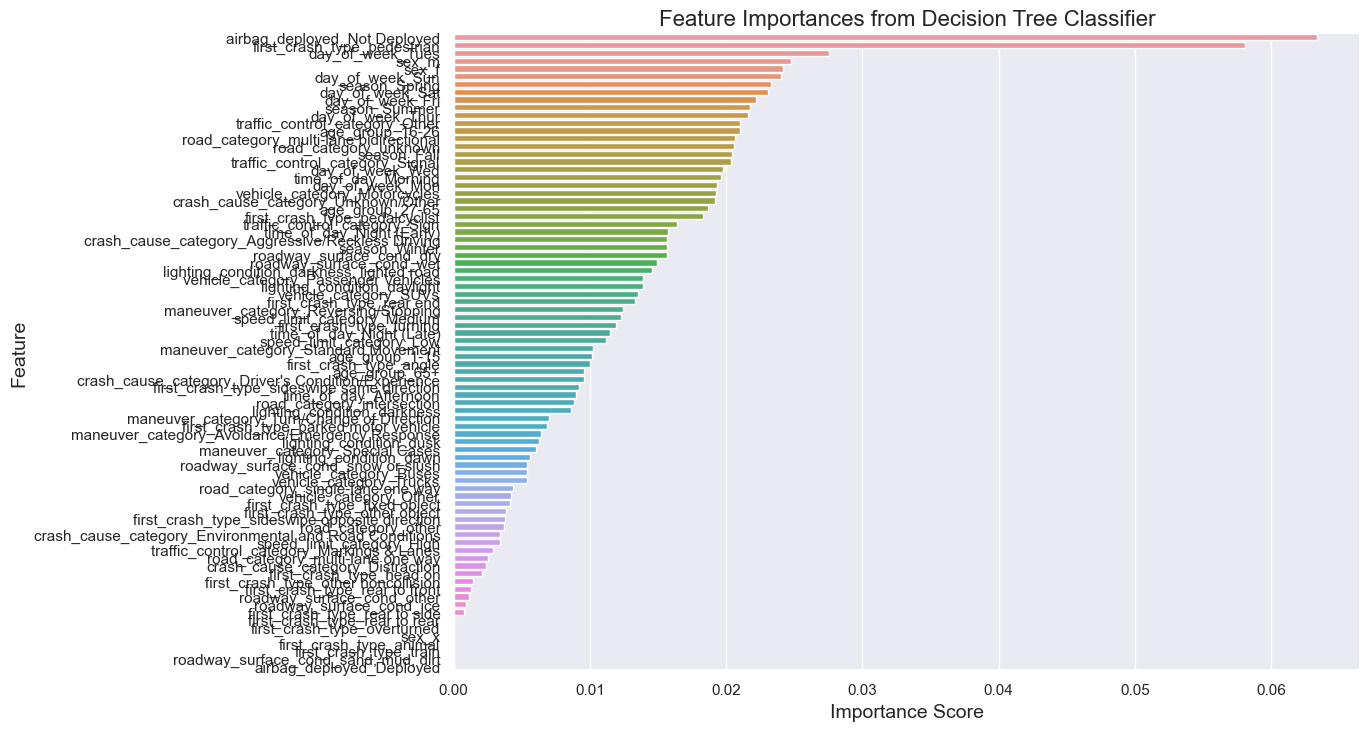

In [171]:
# Start the timer
start_time = time.time()

# Step 1: Preprocessing the data with OneHotEncoder for categorical features
ohe = OneHotEncoder(sparse=False)  # sparse=False to return an array instead of a sparse matrix

# Fit the encoder and transform the categorical features
x_ohe = ohe.fit_transform(x)

# Convert the transformed data into a DataFrame for easy column naming
ohe_df = pd.DataFrame(x_ohe, columns=ohe.get_feature_names_out(x.columns))

# Step 2: Train a Decision Tree Classifier
mgmt_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
mgmt_tree.fit(ohe_df, y)

# Step 3: Use feature_importances_ to get the importance of features
feature_importances = mgmt_tree.feature_importances_

# Step 4: Sort and visualize feature importances
sorted_indices = feature_importances.argsort()[::-1]  # Sort in descending order
sorted_feature_names = ohe_df.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7, 8.27)})  # Set the plot size
sns.barplot(x=sorted_importances, y=sorted_feature_names)

# Add title and labels
plt.title('Feature Importances from Decision Tree Classifier', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Increase tick mark size
plt.tick_params(axis='both', which='major', labelsize=11)

# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Save the plot if desired and display it
plt.savefig("./images/feature_importances.png", dpi=300, bbox_inches='tight')
plt.show()

In [172]:
# Get the top 20 and bottom 20 feature importances
top_20_features = sorted_feature_names[:20]
top_20_importances = sorted_importances[:20]

bottom_20_features = sorted_feature_names[-20:]
bottom_20_importances = sorted_importances[-20:]

# Create a DataFrame for the top 20 features
top_20_df = pd.DataFrame({
    'Feature': top_20_features,
    'Importance': top_20_importances
})

# Create a DataFrame for the bottom 20 features
bottom_20_df = pd.DataFrame({
    'Feature': bottom_20_features,
    'Importance': bottom_20_importances
})

In [173]:
# Print the top 20 and bottom 20 features and their importance scores
print("Top 20 Features:")
top_20_df

Top 20 Features:


,Feature,Importance
0,airbag_deployed_Not Deployed,0.063370
1,first_crash_type_pedestrian,0.058067
2,day_of_week_Tues,0.027576
3,sex_m,0.024740
4,sex_f,0.024161
5,day_of_week_Sun,0.024013
6,season_Spring,0.023265
7,day_of_week_Sat,0.023034
8,day_of_week_Fri,0.022213
9,season_Summer,0.021723


In [174]:
def get_original_feature(encoded_feature_name):
    """
    Extracts the original feature name from the encoded feature name.

    Assumes the encoded feature name is of the form:
    - Original feature name followed by an underscore and then a category.

    For example:
    - 'sex_Male' should return 'sex'
    - 'age_group_0-18' should return 'age_group'
    - 'vehicle_category_SUV' should return 'vehicle_category'

    Handles cases where the original feature has underscores in its name.
    """
    # This will correctly split at the first underscore and return the original feature
    # without mistakenly splitting into parts of the original feature name
    return '_'.join(encoded_feature_name.split('_')[:-1])

# Example tests
print(get_original_feature('sex_Male'))  # Output: 'sex'
print(get_original_feature('age_group_0-18'))  # Output: 'age_group'
print(get_original_feature('vehicle_category_SUV'))  # Output: 'vehicle_category'
print(get_original_feature('first_crash_type_Accident'))  # Output: 'first_crash_type'

sex
age_group
vehicle_category
first_crash_type


In [175]:
# Add a column for the original feature to the top 20 DataFrame
top_20_df['Original Feature'] = top_20_df['Feature'].apply(get_original_feature)

In [176]:
# Now, you can preview the top 20 and bottom 20 with their original features
print("Top 20 Features:")
top_20_df

Top 20 Features:


,Feature,Importance,Original Feature
0,airbag_deployed_Not Deployed,0.063370,airbag_deployed
1,first_crash_type_pedestrian,0.058067,first_crash_type
2,day_of_week_Tues,0.027576,day_of_week
3,sex_m,0.024740,sex
4,sex_f,0.024161,sex
5,day_of_week_Sun,0.024013,day_of_week
6,season_Spring,0.023265,season
7,day_of_week_Sat,0.023034,day_of_week
8,day_of_week_Fri,0.022213,day_of_week
9,season_Summer,0.021723,season


In [177]:
# Extract the top 25 features and their importance scores
top_20 = top_20_df.head(20)  # or whatever number you want

# Get the original feature name for each top feature
top_20['Original Feature'] = top_20['Feature'].apply(get_original_feature)

# Get the unique original features from the top 25
top_20_original_features = top_20['Original Feature'].unique()

print("Top 25 original features:", top_20_original_features)

Top 25 original features: ['airbag_deployed' 'first_crash_type' 'day_of_week' 'sex' 'season'
 'traffic_control_category' 'age_group' 'road_category' 'time_of_day']


In [178]:
# Get the columns of the merged DataFrame (assuming merged_df is the DataFrame you're working with)
merged_df_columns = merged_df.columns

# Compare the top 25 original features with the columns in merged_df
missing_features = [feature for feature in top_20_original_features if feature not in merged_df_columns]

print("Missing features in merged_df:", missing_features)

Missing features in merged_df: []


## Exporting dataset to kaggle

I save the cleaned dataframe as a csv and manually upload it to kaggle for use in the rest of the project. 

In [179]:
# Save the cleaned and finalized DataFrame to a CSV file in the 'data' directory
crashes_finalized_df.to_csv('./data/crashes_finalized_df.csv', index=False)